<div style="text-align: center; font-size: 40px; font-weight: bold;">
    FILM RECOMMENDATION SYSTEM  
   
</div>

<div style="text-align: center; font-size: 24px;">
    Author: Marta Afifah
</div>


<div style="text-align: left; font-size: 24px; font-weight: bold;">
    Background 
   
</div>

**Membangun Sistem Rekomendasi Film menggunakan Association Rules.**

**Tujuan**: 
1. Menemukan kombinasi film yang sering ditonton oleh pelanggan.
2. Menemukan hubungan atau pola antar film untuk membangun sistem rekomendasi yang dapat memberikan saran film berdasarkan film yang telah ditonton pengguna sebelumnya.




<div style="text-align: left; font-size: 24px; font-weight: bold;">
    Dataset Information
   
</div>

Dataset yang digunakan adalah dataset MovieLens (ml-25m) yang berisi rating bintang 5 dan aktivitas tagging teks bebas dari MovieLens, sebuah layanan rekomendasi film. Dataset ini berisi 27753444 rating dan 1.129 aplikasi tag dari sekitar 62.000 film. Data ini dibuat oleh 162.000 pengguna dan dirilis pada Desember 2019. Dataset terdiri dari:

- **Data Film** <br>
Dataset ini berisi judul film dan unique value dari setiap film tanpa nilai duplikat

- **Data Tages Film** <br>
Dataset ini berisi tag yang ditambahkan ke film ditambah dengan ID pengguna yang bernilai untuk dipertimbangkan sebagai indeks untuk setiap transaksi, Di sisi lain, dataset ini memiliki jumlah ID film yang lebih sedikit daripada dataset peringkat  yang membuat kami memilihnya.

- **Data Rating Film** <br>
Dataset ini berisi tag yang ditambahkan ke film ditambah dengan ID pengguna yang bernilai untuk dipertimbangkan sebagai indeks untuk setiap transaksi, Di sisi lain, dataset ini memiliki jumlah ID film yang lebih sedikit daripada dataset peringkat  yang membuat kami memilihnya.

# **0 - Import Data & Library**

In [1]:
# pip install mlxtend
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import mlxtend as ml
from scipy import sparse
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth

## **Dataset**

In [ ]:
# Import dataset dari MovieLens
import requests, zipfile, io
zipfile.ZipFile(io.BytesIO(requests.get('https://files.grouplens.org/datasets/movielens/ml-25m.zip').content)).extractall()

## **Selecting Data**

In [ ]:
ls -a ml-25m

In [2]:
data_movies = pd.read_csv('ml-25m/movies.csv')
data_tages = pd.read_csv('ml-25m/tags.csv')
data_ratings = pd.read_csv('ml-25m/ratings.csv')

## **Exploratory**

In [3]:
# Data Film
data_movies.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
data_movies.movieId.value_counts(), print('Number of duplicated unique ids are: ',data_movies.movieId.duplicated().sum())

Number of duplicated unique ids are:  0


(movieId
 1         1
 162130    1
 162070    1
 162072    1
 162074    1
          ..
 107614    1
 107623    1
 107625    1
 107630    1
 209171    1
 Name: count, Length: 62423, dtype: int64,
 None)

In [5]:
# Data Tages Film
data_tages.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [6]:
data_tages.movieId.value_counts()

movieId
260       6180
79132     4767
296       4767
109487    3616
2959      3612
          ... 
128798       1
183647       1
183605       1
128884       1
128534       1
Name: count, Length: 45251, dtype: int64

In [7]:
# Data Ratings Film
data_ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [8]:
data_ratings.movieId.value_counts()

movieId
356       81491
318       81482
296       79672
593       74127
2571      72674
          ...  
193109        1
112393        1
142793        1
111842        1
200728        1
Name: count, Length: 59047, dtype: int64

# **1 - Preprocessing**

### **Merging Dataset** <br>

Dalam kasus ini, inner join dipilih karena saya memerlukan data hanya ketika label movieId ada di kedua dataset (Data Film dan Data Tages).







In [9]:
merge = data_movies.merge(data_tages,on = 'movieId',how = 'inner')
merge.head(3)

,movieId,title,genres,userId,tag,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,791,Owned,1515175493
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1048,imdb top 250,1172144394
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1361,Pixar,1216146311


### **Drop Variable** <br>
Drop variabel yang tidak diperlukan

In [10]:
merge.drop(columns=['tag','timestamp','genres'],inplace=True)
merge.head(3)

,movieId,title,userId
0,1,Toy Story (1995),791
1,1,Toy Story (1995),1048
2,1,Toy Story (1995),1361


### **Duplikasi Data**

In [11]:
# Cek duplikasi data
merge.duplicated().any()

True

In [12]:
# Menghapus data yang terduplikasi
merge.drop_duplicates(inplace= True)

In [13]:
len(merge.userId.unique())

14592

In [14]:
merge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 305356 entries, 0 to 1093351
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   movieId  305356 non-null  int64 
 1   title    305356 non-null  object
 2   userId   305356 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


### **Daftar film yang ditonton setiap pengguna**

Dilakukan preprocessing dataset untuk membuat daftar transaksi di mana setiap baris mewakili seorang pengguna dan film yang dipilihnya menggunakan groupby.

In [15]:
merge_list = merge.groupby('userId')['title'].apply(list).reset_index()
merge_list.head(3)

,userId,title
0,3,[Star Wars: Episode IV - A New Hope (1977)]
1,4,"[Big Lebowski, The (1998), You Only Live Twice..."
2,19,"[Rosemary's Baby (1968), Nausicaä of the Valle..."



Validasi daftar yang dibuat per userId.

In [16]:
print(len(merge.title.unique()))

45208


In [17]:
print(len(merge.userId.unique()))
print(len(merge_list))

14592
14592


### **Transformasi Data** <br>
Di sini data ditransformasi menjadi binary input untuk diterima oleh algoritma.<br>

In [18]:
# Encoding data dengan MultiLabelBInarizer
mlb = MultiLabelBinarizer()

#Transformasi menjadi bentuk biner
binary = mlb.fit_transform(merge_list['title'])

#Mengubah ke bentuk data frame
df = pd.DataFrame(binary, columns = mlb.classes_)

df.head()

,"""Great Performances"" Cats (1998)",#1 Cheerleader Camp (2010),#Captured (2017),#FollowMe (2019),#Horror (2015),#Stuck (2014),#realityhigh (2017),$ (Dollars) (1971),"$1,000 on the Black (1966)","$100,000 for Ringo (1965)",$9.99 (2008),$ellebrity (Sellebrity) (2012),'49-'17 (1917),'63 Boycott (2016),'68 (1988),'71 (2014),'Gator Bait (1974),'Hellboy': The Seeds of Creation (2004),"'Human' Factor, The (Human Factor, The) (1975)",'Master Harold' ... And the Boys (2010),'Neath Brooklyn Bridge (1942),'Neath the Arizona Skies (1934),'Pimpernel' Smith (1941),'R Xmas (2001),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Twas the Night (2001),'Twas the Night Before Christmas (1974),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),(A)sexual (2011),(Dis)Honesty: The Truth About Lies (2015),(T)ERROR (2015),(The New) War of the Buttons (2011),(Untitled) (2009),*batteries not included (1987),+1 (2013),...All the Marbles (1981),...And God Spoke (1993),...And Justice for All (1979),...First Do No Harm (1997),...ing (2003),...tick... tick... tick... (1970),.45 (2006),.hack Liminality: In the Case of Mai Minase,.hack//Beyond the World (2012),008: Operation Exterminate (1966),009 Re: Cyborg (2012),009-1: The End of the Beginning (2013),1 (2013),1 (2014),1 Buck (2017),1 Chance 2 Dance (2014),1 Night (2017),1. Mai (2008),10 (1979),10 Billion: What's On Your Plate (2015),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Days in a Madhouse (2015),10 Items or Less (2006),10 Questions for the Dalai Lama (2006),10 Rillington Place (1971),10 Rules for Sleeping Around (2013),10 Things I Hate About You (1999),10 Years (2011),10 minutes (10 minuta) (2002),10 to Midnight (1983),10%: What Makes a Hero? (2013),10+10 (2011),"10,000 BC (2008)","10,000 Black Men Named George (2002)","10,000 Dollars for a Massacre (1967)",10.0 Earthquake (2014),100 Bloody Acres (2012),100 Days (1991),100 Days Before the Command (1991),100 Days Of Love (2015),100 Days With Mr. Arrogant (2004),100 Degrees Below Zero (2013),100 Dinge (2018),100 Feet (2008),100 Girls (2000),100 Men and a Girl (One Hundred Men and a Girl) (1937),100 Million BC (2008),100 Poems for Stella (2017),100 Rifles (1969),100 Streets (2016),100 Women (2002),100 Years at the Movies (1994),100 Yen Love (2014),100 Yen: The Japanese Arcade Experience (2012),100 metros (2016),100% Love (2011),"1000 Eyes of Dr. Mabuse, The (Die 1000 Augen des Dr. Mabuse) (1960)",1000 Journals (2007),1001 Nights (1990),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Rent Boys (2000),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),102 Minutes That Changed America (2008),10th & Wolf (2006),"10th Victim, The (La decima vittima) (1965)",10x10 (2018),11 Blocks (2015),11 Days 11 Nights Part 3 (1989),11 Days 11 Nights: Part 1 - Fantasy Becomes Reality (1987),"11 Days, 11 Nights 2 (1990)",11 Harrowhouse (1974),11 Minutes (2015),11 September Vragen (2016),11 x 14 (1977),"11'09""01 - September 11 (2002)",11-11-11 (11-11-11: The Prophecy) (2011),11.22.63 (2016),11/11/11 (2011),11:00 AM (2013),11:14 (2003),11:59 (2005),"11th Hour, The (2007)",12 (2007),12 Angry Men (1957),12 Angry Men (1997),12 Chairs (1971),12 Chairs (1976),12 Dates of Christmas (2011),12 Days of Christmas Eve (2004),"12 Dogs of Christmas, The (2005)",12 Feet Deep (2016),12 Gifts of Christmas (2015),12 Men of Christmas (2009),12 O'Clock Boys (2013),12 Rounds (2009),12 Rounds 3: Lockdown (2015),12 Storeys (Shier lou) (1997),12 Strong (2018),12 Wishes of Christmas (2011),12 Years a Slave (2013),12 registi per 12 città (1989),12 to the Moon (1960),120 (2008),120 Beats Per Minute (2017),125 Years Memory (2015),127 Hours (2010),12:01 (1993),12:08 East of Bucharest (A fost sau n-a fost?) (2006),12th & Delaware (2010),13 (2010),13 Assassins (Jûsan-nin no shikaku) (2010),13 Beloved (13 game sayawng) (2006),13 Cameras (2015),13 Eerie (2013),13 Figh

In [19]:
print(df.shape)

(14592, 45208)


# **2 - Analisis**

## **Frequent Items** <br>
Bagian ini diimplementasikan untuk mencari kombinasi film yang sering ditonton oleh pengguna.

### **Algoritma Apriori** <br>
Nilai minimum support* yang digunakan adalah 1%.

*NB: Support adalah metrik yang digunakan untuk mengukur seberapa sering suatu itemset muncul dalam dataset.

In [20]:
# Frequent Itemset
apriori_frequent_itemsets = apriori(df, min_support = 0.01, use_colnames = True)
apriori_frequent_itemsets

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.014186,((500) Days of Summer (2009))
1,0.013501,(12 Angry Men (1957))
2,0.022135,(2001: A Space Odyssey (1968))
3,0.011856,(28 Days Later (2002))
4,0.014186,(300 (2007))
...,...,...
241,0.010554,"(Seven (a.k.a. Se7en) (1995), Shawshank Redemp..."
242,0.012404,"(Silence of the Lambs, The (1991), Shawshank R..."
243,0.011308,"(Usual Suspects, The (1995), Shawshank Redempt..."
244,0.010280,"(Star Wars: Episode IV - A New Hope (1977), St..."


In [21]:
apriori_frequent_itemsets['itemsets'].apply(lambda x: len(x)).value_counts()

itemsets
1    208
2     37
3      1
Name: count, dtype: int64

In [22]:
# Itemset dengan k = 3
pd.DataFrame(apriori_frequent_itemsets.iloc[245])

,245
support,0.010485
itemsets,(Lord of the Rings: The Fellowship of the Ring...


In [23]:
# Itemset dengan k = 2
pd.DataFrame(apriori_frequent_itemsets.iloc[209:211])

,support,itemsets
209,0.010896,"(Fight Club (1999), Donnie Darko (2001))"
210,0.010759,"(Donnie Darko (2001), Pulp Fiction (1994))"


In [24]:
# Itemset dengan k = 1
pd.DataFrame(apriori_frequent_itemsets.iloc[:3])

,support,itemsets
0,0.014186,((500) Days of Summer (2009))
1,0.013501,(12 Angry Men (1957))
2,0.022135,(2001: A Space Odyssey (1968))


In [25]:
apriori_frequent_itemsets['support'].describe()

count    246.000000
mean       0.016141
std        0.011124
min        0.010005
25%        0.011376
50%        0.013501
75%        0.016927
max        0.149191
Name: support, dtype: float64

## **Association Rule<br>**
Bagian ini diimplementasikan untuk menganalisi pola hubungan antar film utuk membangun sistem rekomendasi.

In [26]:
# Membuat association rules
rules = association_rules(apriori_frequent_itemsets, metric = 'confidence', min_threshold = 0.1)

In [27]:
# Mengurutkan association rules yang terbentuk berdasarkan metrik confidence dan lift
rules = rules.sort_values(by=['confidence','lift'], ascending = False)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
73,"(Lord of the Rings: The Two Towers, The (2002)...",(Lord of the Rings: The Fellowship of the Ring...,0.011719,0.023438,0.010485,0.894737,38.175439,1.0,0.010211,9.277344,0.985352,0.425000,0.892211,0.671053
72,(Lord of the Rings: The Fellowship of the Ring...,"(Lord of the Rings: The Two Towers, The (2002))",0.012061,0.018846,0.010485,0.869318,46.127603,1.0,0.010258,7.507961,0.990265,0.513423,0.866808,0.712841
71,(Lord of the Rings: The Fellowship of the Ring...,"(Lord of the Rings: The Return of the King, Th...",0.012404,0.021245,0.010485,0.845304,39.789271,1.0,0.010222,6.326955,0.987112,0.452663,0.841946,0.669426
40,"(Lord of the Rings: The Two Towers, The (2002))",(Lord of the Rings: The Fellowship of the Ring...,0.018846,0.023438,0.012404,0.658182,28.082424,1.0,0.011962,2.856965,0.982914,0.415138,0.649978,0.593711
70,(Star Wars: Episode V - The Empire Strikes Bac...,(Star Wars: Episode IV - A New Hope (1977)),0.016447,0.149191,0.010280,0.625000,4.189251,1.0,0.007826,2.268823,0.774025,0.066167,0.559243,0.346951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,(Pulp Fiction (1994)),(Seven (a.k.a. Se7en) (1995)),0.064693,0.027070,0.010896,0.168432,6.222184,1.0,0.009145,1.169995,0.897336,0.134746,0.145296,0.285482
5,(Pulp Fiction (1994)),(Donnie Darko (2001)),0.064693,0.030359,0.010759,0.166314,5.478211,1.0,0.008795,1.163076,0.874000,0.127642,0.140211,0.260358
60,(Pulp Fiction (1994)),(Twelve Monkeys (a.k.a. 12 Monkeys) (1995)),0.064693,0.023712,0.010622,0.164195,6.924660,1.0,0.009088,1.168081,0.914768,0.136564,0.143895,0.306086
8,(Pulp Fiction (1994)),(Eternal Sunshine of the Spotless Mind (2004)),0.064693,0.031867,0.010280,0.158898,4.986331,1.0,0.008218,1.151030,0.854748,0.119142,0.131213,0.240739


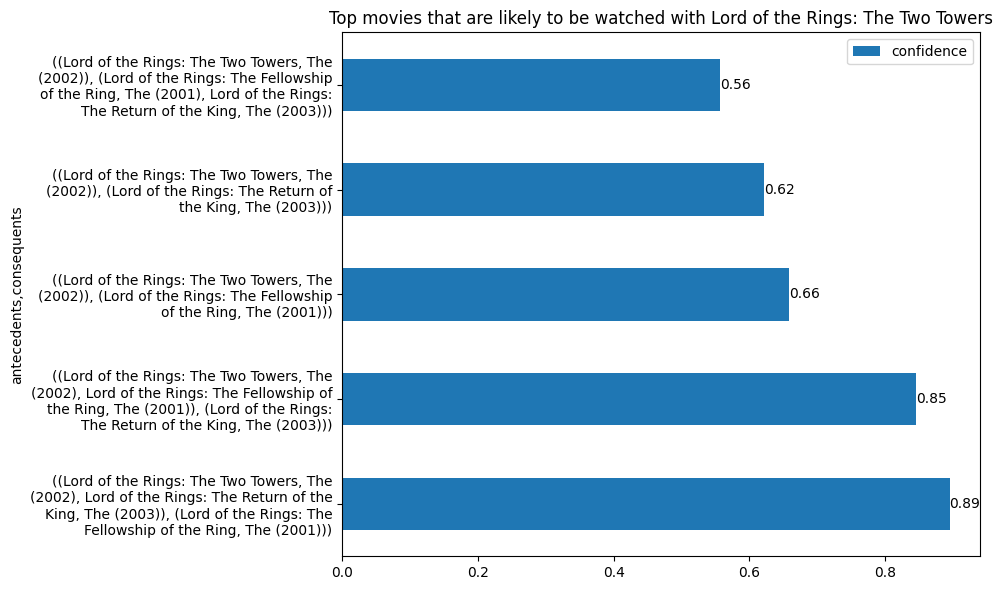

In [28]:
import matplotlib.pyplot as plt
import textwrap

ax = rules[rules["antecedents"].apply(lambda x: "Lord of the Rings: The Two Towers" in str(x))]\
    .groupby(['antecedents', 'consequents'])[['confidence']]\
    .max().sort_values(ascending=False, by='confidence')\
    .head(10).plot(kind='barh', figsize=(10, 6))

plt.title('Top movies that are likely to be watched with Lord of the Rings: The Two Towers')

for i in ax.patches:
    ax.text(i.get_width(), i.get_y() + i.get_height() / 2,
            f'{i.get_width():.2f}', va='center', ha='left', fontsize=10)

max_len = 45 
current_labels = [label.get_text() for label in ax.get_yticklabels()]
wrapped_labels = [textwrap.fill(label, max_len) for label in current_labels]
ax.set_yticklabels(wrapped_labels)

plt.tight_layout()
plt.show()


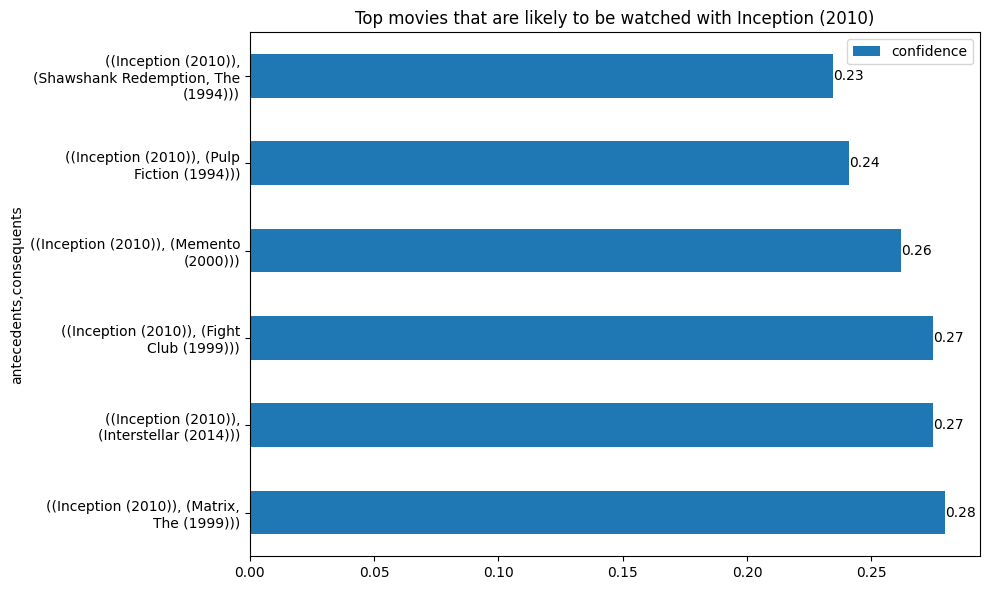

In [29]:
import matplotlib.pyplot as plt
import textwrap

ax = rules[rules["antecedents"].apply(lambda x: "Inception (2010)" in str(x))]\
    .groupby(['antecedents', 'consequents'])[['confidence']]\
    .max().sort_values(ascending=False, by='confidence')\
    .head(10).plot(kind='barh', figsize=(10, 6))

plt.title('Top movies that are likely to be watched with Inception (2010)')

for i in ax.patches:
    ax.text(i.get_width(), i.get_y() + i.get_height() / 2,
            f'{i.get_width():.2f}', va='center', ha='left', fontsize=10)

max_len = 30 
current_labels = [label.get_text() for label in ax.get_yticklabels()]
wrapped_labels = [textwrap.fill(label, max_len) for label in current_labels]
ax.set_yticklabels(wrapped_labels)

plt.tight_layout()
plt.show()


# **3 - Visualisasi  Association  Rules  with   (Networkx)** <br>
Visualisasi jaringan antar film berdasarkan aturan asosiasi

In [ ]:
# !pip install nbformat==5.1.2

Reason for being yanked: Name generation process created inappropriate id values

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip



  Using cached jsonschema-4.23.0-py3-none-any.whl.metadata (7.9 kB)
  Using cached jsonschema_specifications-2024.10.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached rpds_py-0.22.3-cp312-cp312-win_amd64.whl.metadata (4.2 kB)


In [85]:
rules['antecedents'] = rules.antecedents.apply(lambda x: next(iter(x)))
rules['consequents'] = rules.consequents.apply(lambda x: next(iter(x)))

In [43]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

import networkx as nx
import warnings
warnings.filterwarnings('ignore')

init_notebook_mode(connected=True)

# Create a Plotly figure
fig = go.Figure()

edges = nx.from_pandas_edgelist(rules.sort_values(ascending=False,by='lift')
                           ,source='antecedents',target='consequents',edge_attr=None)
pos = nx.spring_layout(edges, seed=42)  # use spring_layout instead
# Add edges as scatter trace
edge_x = []
edge_y = []
for edge in edges.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

fig.add_trace(edge_trace)

# Add nodes as scatter trace
node_x = []
node_y = []
node_text = []
for node in edges.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(node)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',  # Tambahkan teks langsung
    text=node_text,  # Gunakan teks label dari node
    textposition='top center',  # Posisikan teks di atas titik
    hoverinfo='text',
    textfont=dict(size=7),
    marker=dict(
        showscale=False,
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        line_width=2)
)


node_trace.text = node_text
fig.add_trace(node_trace)

# Set layout and display the figure
fig.update_layout(
    title='Top 100 movies in term of (lift)',
    title_font_size=25,
    font_size=18,
    showlegend=False,
    hovermode='closest',
    margin=dict(b=20,l=10,r=5,t=40),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))

iplot(fig)